# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

import sys
import pandas as pd

if '../../../../notebooks/' not in sys.path:
    sys.path.append('../../../../notebooks/')
if 'src' not in sys.path:
    sys.path.insert(0, 'src')

import utils.constants as cts

from data_loaders.data_loader import DLName
from gt_loaders.gt_names import GTName
from exp_runner import ExperimentRunner
from base.model_evaluator import DataSource, DataPredSelection
from base.base_models import BaseModel
from base.optimizers import Optimizer
from base.model_creator import MTLApproach, NAS_MTLApproach

 ==> Restrict GPU memory growth: True


# Start Network runner

In [4]:
kwargs = { 
    'use_neptune': False,
    'exp_params' : {
        'name': 'neural_arch_search',
        'description': 'Making NAS with APPROACH_1 (random) and training best architecture for 50 epochs to evaluate on test set',
        'tags': ['ground truths', 'nas', 'nas_approach_1'],
        'src_files': ["src/**/*.py"]
    },
    'properties': {
        'approach': NAS_MTLApproach.APPROACH_2,
        'reqs': list(cts.ICAO_REQ),
        'aligned': True,
        'use_gt_data': True,
        'gt_names': {
            'train_validation': [],
            'test': [],
            'train_validation_test': [GTName.FVC]
        },
        'balance_input_data': False,
        'train_model': True,
        'save_trained_model': True,
        'exec_nas': True,
        'orig_model_experiment_id': '',
        'sample_training_data': False,
        'sample_prop': 1.0
    },
    'net_train_params': {
        'base_model': BaseModel.VGG16,
        'batch_size': 32,
        'n_epochs': 50,
        'early_stopping': 99,
        'learning_rate': 1e-3,
        'optimizer': Optimizer.ADAMAX,
        'dropout': 0.3
    },
    'nas_params': {
        'max_blocks_per_branch': 5,
        'controller_epochs': 50,
        'controller_batch_size': 32,
        'n_trials': 3
    }
}

runner = ExperimentRunner(**kwargs)

-------------------- Init ExperimentRunner -------------------
---------------------------
Parent Process ID: 112431
Process ID: 124122
---------------------------
-----
Use Neptune:  False
-----
-------------------
Args: 
{'exp_params': {'description': 'Making NAS with APPROACH_1 (random) and '
                               'training best architecture for 50 epochs to '
                               'evaluate on test set',
                'name': 'neural_arch_search',
                'src_files': ['src/**/*.py'],
                'tags': ['ground truths', 'nas', 'nas_approach_1']},
 'nas_params': {'controller_batch_size': 32,
                'controller_epochs': 50,
                'max_blocks_per_branch': 5,
                'n_trials': 3},
 'net_train_params': {'base_model': <BaseModel.VGG16: {'target_size': (224, 224), 'prep_function': <function preprocess_input at 0x7f811d3a4430>}>,
                      'batch_size': 32,
                      'dropout': 0.3,
                     

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Load Data

In [5]:
runner.load_training_data()

-------------------- load training data -------------------
Loading data
Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4926, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)
Data loaded


# <font color='red'>Producing Fake Data</font>

In [6]:
runner.produce_fake_data()

-------------------- producing fake data for experimental purposes -------------------
fake_train_data.shape: (500, 26)
fake_validation_data_df.shape: (100, 26)
fake_test_data_df.shape: (50, 26)


# Data Generators

In [7]:
runner.setup_data_generators()

-------------------- setup data generators -------------------
Starting data generators
Found 500 validated image filenames.
Found 100 validated image filenames.
Found 50 validated image filenames.
TOTAL: 650

Logging class indices
 .. MTL model not logging class indices!

Logging class labels
 COMPLIANT label: 1
 NON_COMPLIANT label: 0
 DUMMY label: -1
 DUMMY_CLS label: 2
 NO_ANSWER label: -99


# Setup Experiment

In [8]:
runner.setup_experiment()

-------------------- create experiment -------------------
Not using Neptune


# Labels Distribution

In [9]:
%%capture
runner.summary_labels_dist()

# Neural Architecture Search

In [10]:
runner.run_neural_architeture_search()

-------------------- run neural architecture search -------------------
Executing neural architectural search
++++++++++++++++++++ STARTING NEW TRAIN ++++++++++++++++++++
 selecting new config...
 controller_pred: [[0.3441619  0.20514262 0.22418945 0.22650607]]
 ----- Training 1 | Config: {'n_denses_0': 5, 'n_denses_1': 1, 'n_denses_2': 1, 'n_denses_3': 1} --------
Creating model...
Model created
Training VGG16 network
 .. Not fine tuning base model...
  .. Total params: 15,589,294
  .. Trainable params: 874,606
  .. Non-trainable params: 14,714,688
15/15 [==============================] - 21s 667ms/step - loss: 2.0811 - background_loss: 0.6943 - close_loss: 0.7327 - ink_mark_loss: 0.7030 - pixelation_loss: 0.8668 - washed_out_loss: 0.7535 - blurred_loss: 0.7680 - sh_head_loss: 0.7194 - mouth_loss: 1.0931 - veil_loss: 0.8956 - red_eyes_loss: 0.8190 - flash_lenses_loss: 0.9583 - dark_glasses_loss: 0.8974 - l_away_loss: 1.1950 - frame_eyes_loss: 0.9408 - hair_eyes_loss: 0.9754 - eyes_clo

# Create Model

In [15]:
best_config = {'n_denses_0': 5, 'n_denses_1': 1, 'n_denses_2': 4, 'n_denses_3': 5}
runner.create_model(best_config)

-------------------- create model -------------------
Creating model...
Model created


# Visualize Model

-------------------- vizualize model -------------------


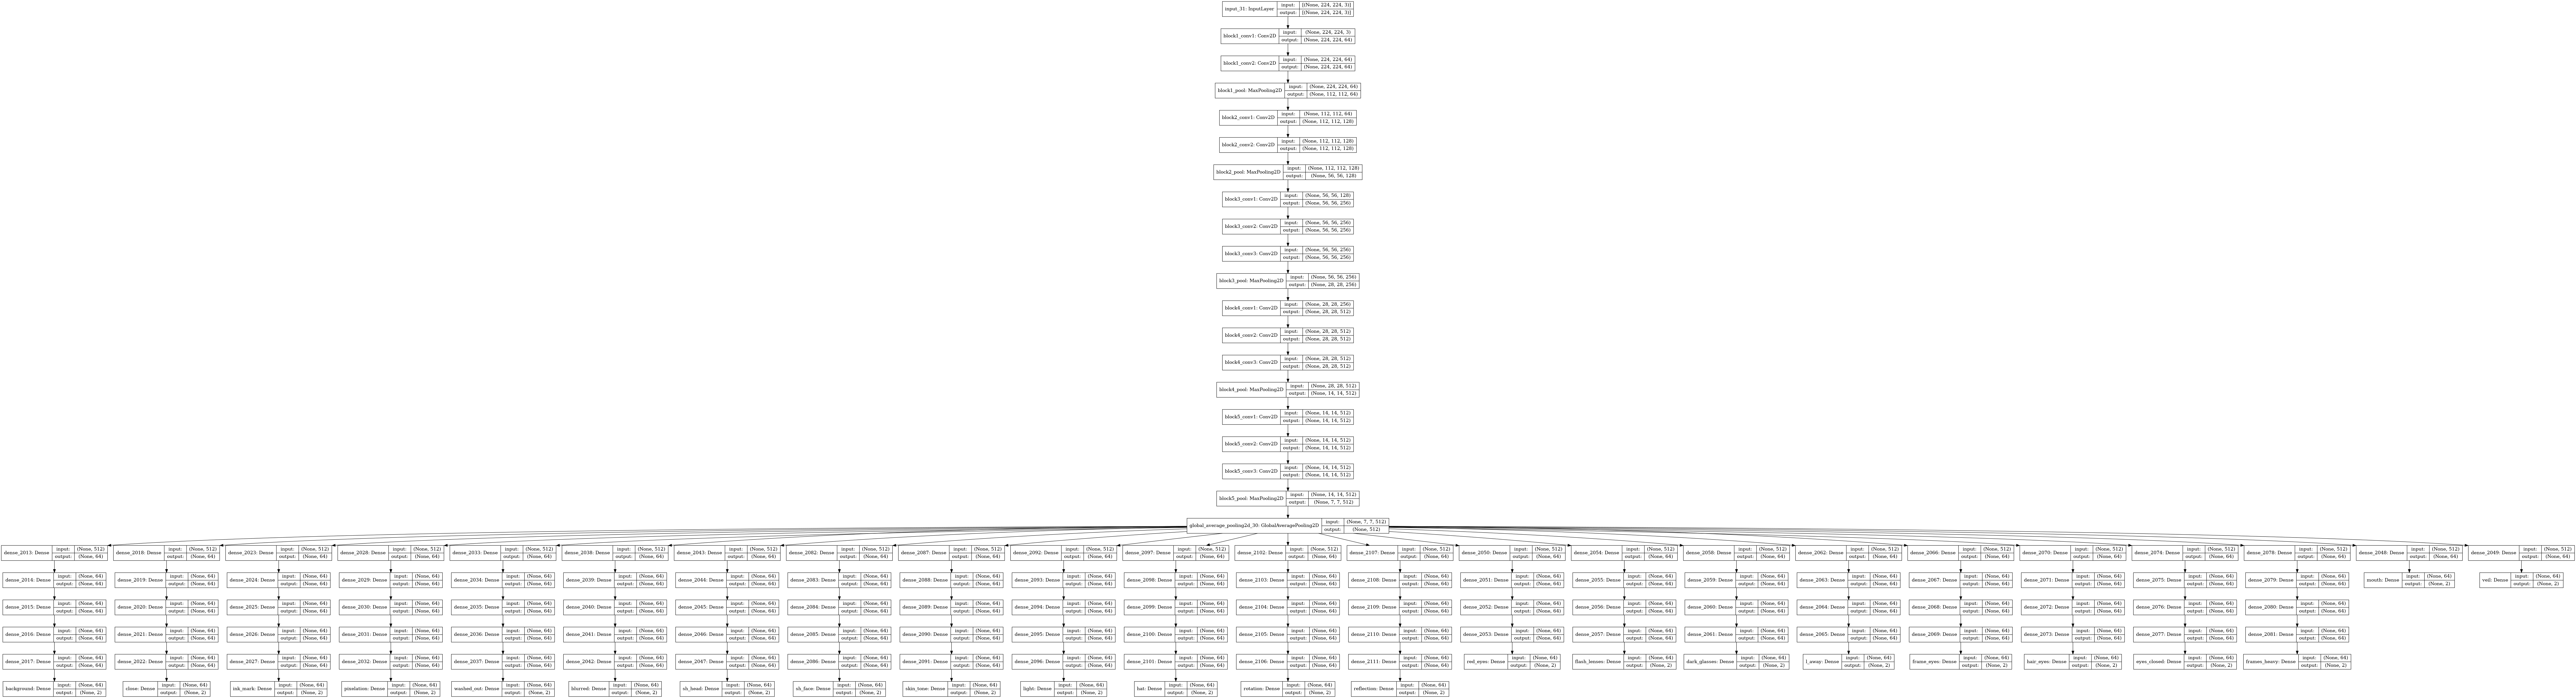

In [16]:
runner.visualize_model(outfile_path=f"figs/nas/nas_model_approach_1.png")

In [17]:
%%capture
runner.model_summary()

# Training Model

In [18]:
runner.train_model()

-------------------- train model -------------------
Training VGG16 network
 .. Not fine tuning base model...
  .. Total params: 15,788,974
  .. Trainable params: 1,074,286
  .. Non-trainable params: 14,714,688
Epoch 1/2
154/154 [==============================] - 345s 2s/step - loss: 1.0237 - background_loss: 0.6103 - close_loss: 0.5612 - ink_mark_loss: 0.6237 - pixelation_loss: 0.5351 - washed_out_loss: 0.0852 - blurred_loss: 0.4393 - sh_head_loss: 0.3740 - mouth_loss: 0.0438 - veil_loss: 0.6456 - red_eyes_loss: 0.5430 - flash_lenses_loss: 0.2695 - dark_glasses_loss: 0.7061 - l_away_loss: 0.3241 - frame_eyes_loss: 0.6766 - hair_eyes_loss: 0.6732 - eyes_closed_loss: 0.3618 - frames_heavy_loss: 0.0196 - sh_face_loss: 0.6943 - skin_tone_loss: 0.0572 - light_loss: 0.2811 - hat_loss: 0.4800 - rotation_loss: 0.6865 - reflection_loss: 0.5462 - background_accuracy: 0.7265 - close_accuracy: 0.7453 - ink_mark_accuracy: 0.6798 - pixelation_accuracy: 0.7792 - washed_out_accuracy: 0.9876 - blurred

# Plots

-------------------- draw training history -------------------


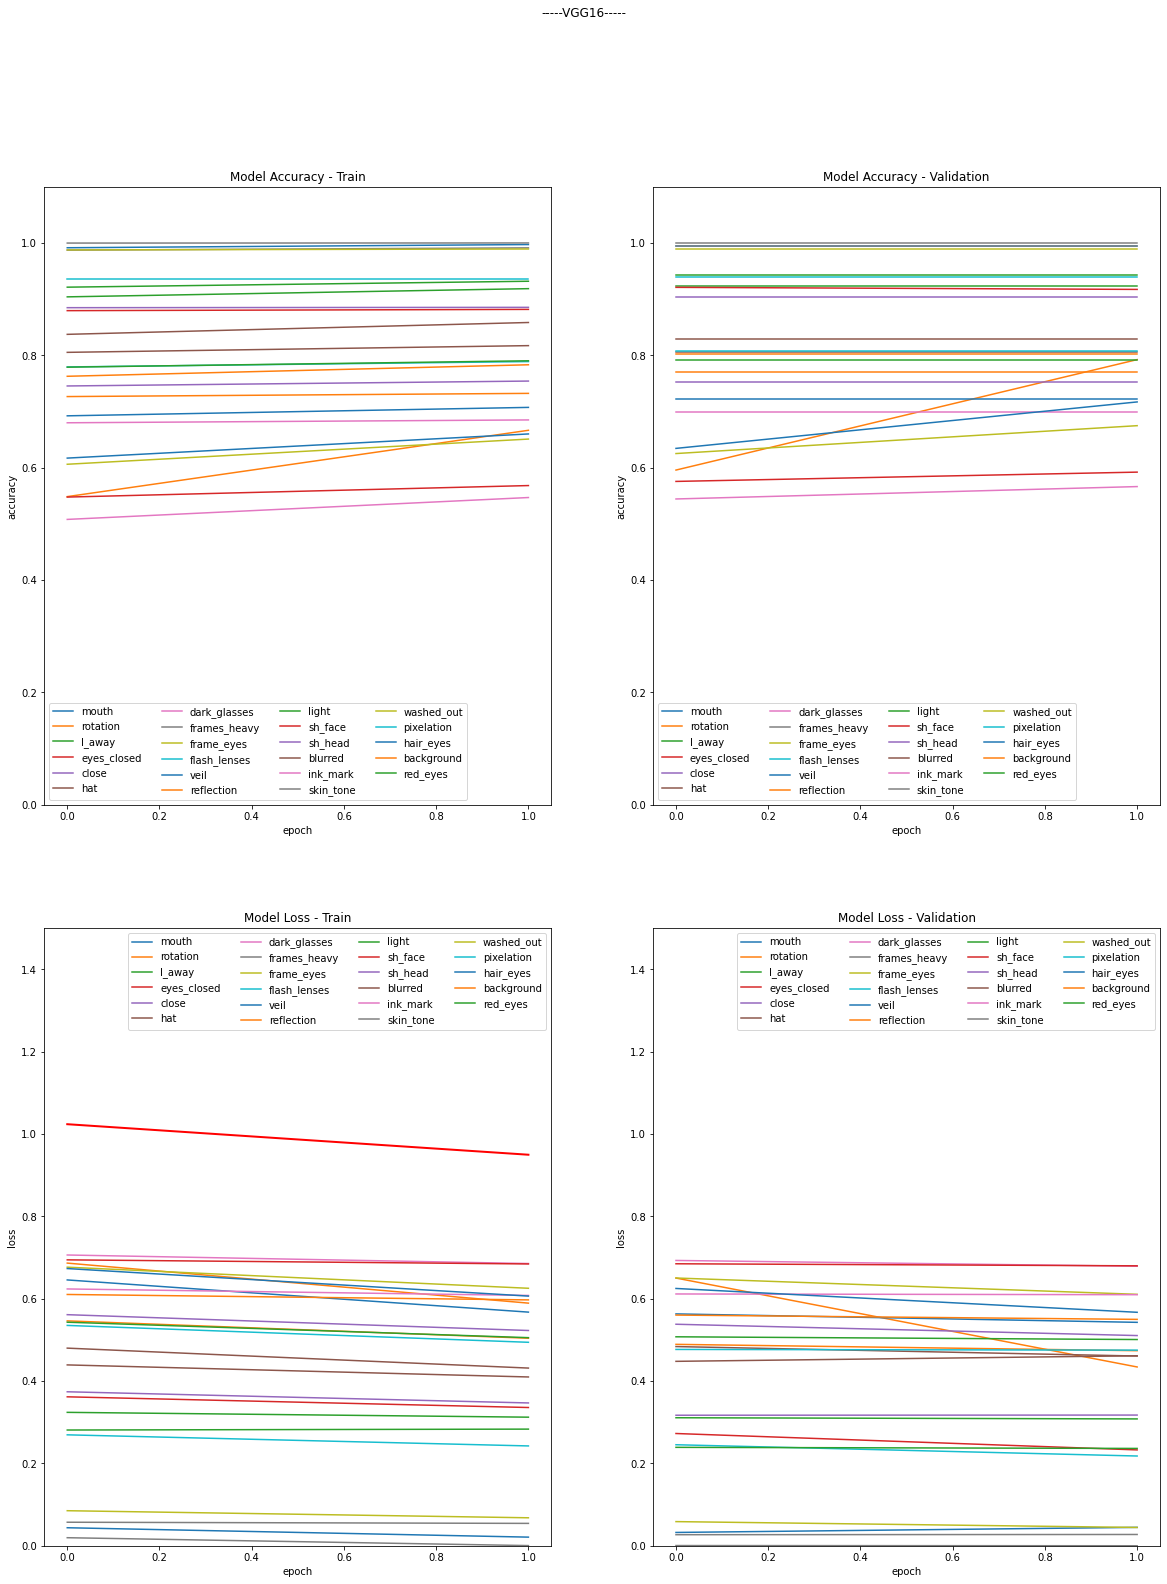

In [19]:
runner.draw_training_history()

# Load Best Model

In [20]:
runner.load_best_model()

-------------------- load best model -------------------
..Loading best model
..Checkpoint weights loaded


# Saving Trained Model

In [21]:
runner.save_model()

-------------------- save model -------------------
Saving model
INFO:tensorflow:Assets written to: trained_model/assets
..Model saved
...Model path: trained_model
Saving process finished


# Test Trained Model

## Validation Split

Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!
Requisite: MOUTH


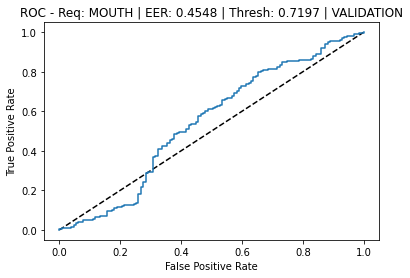

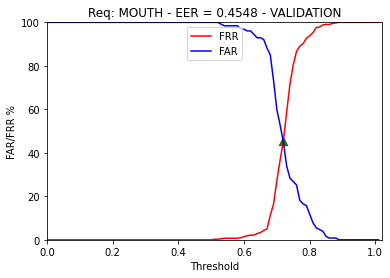

Requisite: MOUTH - EER_interp: 45.48% - Best Threshold: 0.7196865413870133
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.27      0.55      0.36       127
    COMPLIANT       0.80      0.55      0.65       420

     accuracy                           0.55       547
    macro avg       0.53      0.55      0.50       547
 weighted avg       0.68      0.55      0.58       547

Confusion matrix ----------------------------------------
FAR: 44.879999999999995% | FRR: 45.48% | EER_mean: 45.18% | TP: 229 | TN: 70 | FP: 57 | FN: 191
Accuracy ------------------------------------------------
Model Accuracy: 54.66%
---------------------------------------------------------
Requisite: ROTATION


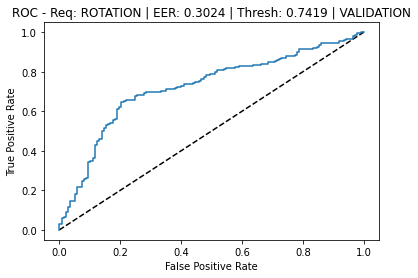

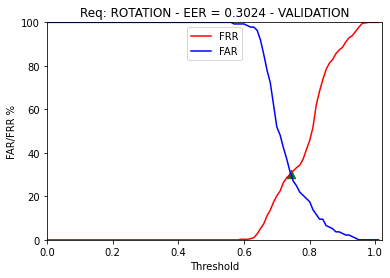

Requisite: ROTATION - EER_interp: 30.240000000000002% - Best Threshold: 0.7418814368364328
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.44      0.71      0.54       137
    COMPLIANT       0.88      0.70      0.78       410

     accuracy                           0.70       547
    macro avg       0.66      0.70      0.66       547
 weighted avg       0.77      0.70      0.72       547

Confusion matrix ----------------------------------------
FAR: 29.2% | FRR: 30.240000000000002% | EER_mean: 29.720000000000002% | TP: 286 | TN: 97 | FP: 40 | FN: 124
Accuracy ------------------------------------------------
Model Accuracy: 70.02000000000001%
---------------------------------------------------------
Requisite: L_AWAY


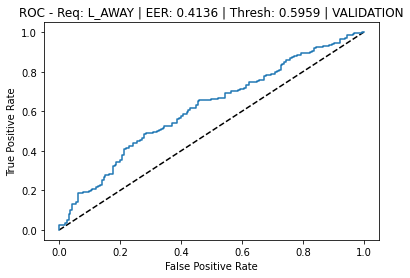

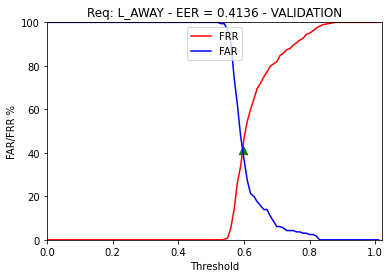

Requisite: L_AWAY - EER_interp: 41.36% - Best Threshold: 0.5958807122020822
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.38      0.59      0.46       165
    COMPLIANT       0.77      0.59      0.66       382

     accuracy                           0.59       547
    macro avg       0.57      0.59      0.56       547
 weighted avg       0.65      0.59      0.60       547

Confusion matrix ----------------------------------------
FAR: 41.21% | FRR: 41.36% | EER_mean: 41.29% | TP: 224 | TN: 97 | FP: 68 | FN: 158
Accuracy ------------------------------------------------
Model Accuracy: 58.68%
---------------------------------------------------------
Requisite: EYES_CLOSED


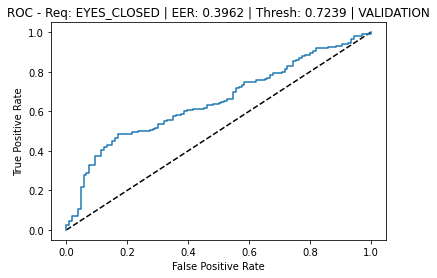

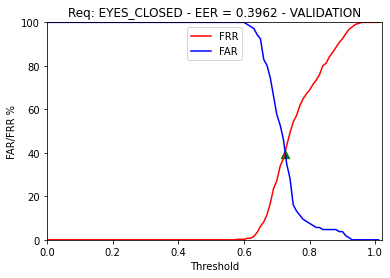

Requisite: EYES_CLOSED - EER_interp: 39.62% - Best Threshold: 0.7239427566528231
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.27      0.60      0.37       106
    COMPLIANT       0.86      0.61      0.71       441

     accuracy                           0.61       547
    macro avg       0.57      0.60      0.54       547
 weighted avg       0.75      0.61      0.65       547

Confusion matrix ----------------------------------------
FAR: 39.62% | FRR: 39.46% | EER_mean: 39.54% | TP: 267 | TN: 64 | FP: 42 | FN: 174
Accuracy ------------------------------------------------
Model Accuracy: 60.51%
---------------------------------------------------------
Requisite: CLOSE


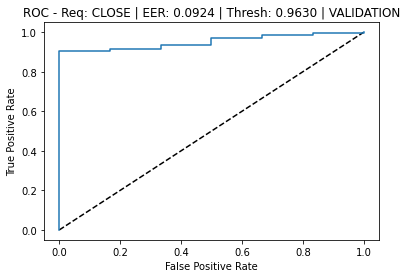

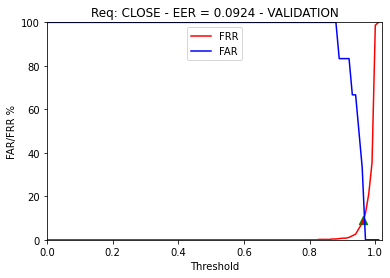

Requisite: CLOSE - EER_interp: 9.24% - Best Threshold: 0.9629950256753103
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.11      1.00      0.19         6
    COMPLIANT       1.00      0.91      0.95       541

     accuracy                           0.91       547
    macro avg       0.55      0.95      0.57       547
 weighted avg       0.99      0.91      0.94       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 9.24% | EER_mean: 4.62% | TP: 491 | TN: 6 | FP: 0 | FN: 50
Accuracy ------------------------------------------------
Model Accuracy: 90.86%
---------------------------------------------------------
Requisite: HAT


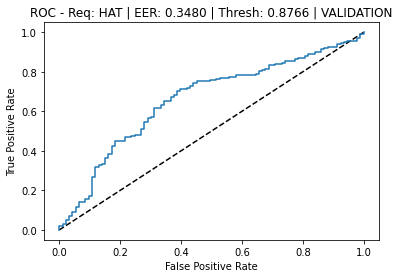

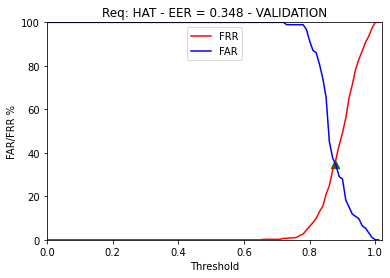

Requisite: HAT - EER_interp: 34.8% - Best Threshold: 0.8765581262006633
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.28      0.66      0.39        93
    COMPLIANT       0.90      0.65      0.76       454

     accuracy                           0.65       547
    macro avg       0.59      0.65      0.57       547
 weighted avg       0.80      0.65      0.69       547

Confusion matrix ----------------------------------------
FAR: 34.410000000000004% | FRR: 34.8% | EER_mean: 34.599999999999994% | TP: 296 | TN: 61 | FP: 32 | FN: 158
Accuracy ------------------------------------------------
Model Accuracy: 65.27%
---------------------------------------------------------
Requisite: DARK_GLASSES


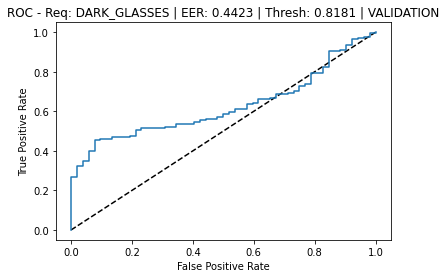

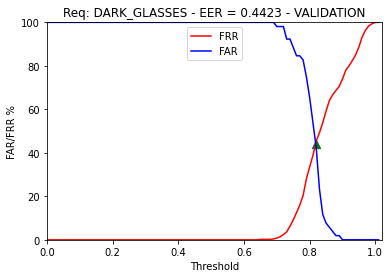

Requisite: DARK_GLASSES - EER_interp: 44.230000000000004% - Best Threshold: 0.8181370496750003
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.12      0.56      0.19        52
    COMPLIANT       0.92      0.56      0.70       495

     accuracy                           0.56       547
    macro avg       0.52      0.56      0.44       547
 weighted avg       0.85      0.56      0.65       547

Confusion matrix ----------------------------------------
FAR: 44.230000000000004% | FRR: 44.24% | EER_mean: 44.24% | TP: 276 | TN: 29 | FP: 23 | FN: 219
Accuracy ------------------------------------------------
Model Accuracy: 55.76%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


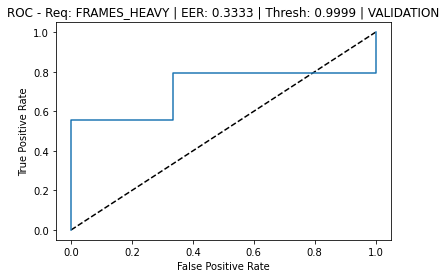

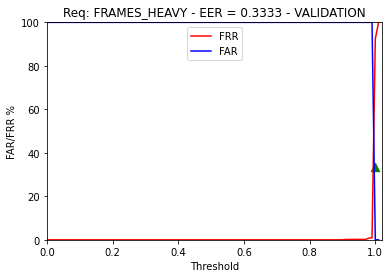

Requisite: FRAMES_HEAVY - EER_interp: 33.33% - Best Threshold: 0.9998729228973389
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.01      0.67      0.02         3
    COMPLIANT       1.00      0.56      0.71       544

     accuracy                           0.56       547
    macro avg       0.50      0.61      0.37       547
 weighted avg       0.99      0.56      0.71       547

Confusion matrix ----------------------------------------
FAR: 33.33% | FRR: 44.3% | EER_mean: 38.82% | TP: 303 | TN: 2 | FP: 1 | FN: 241
Accuracy ------------------------------------------------
Model Accuracy: 55.76%
---------------------------------------------------------
Requisite: FRAME_EYES


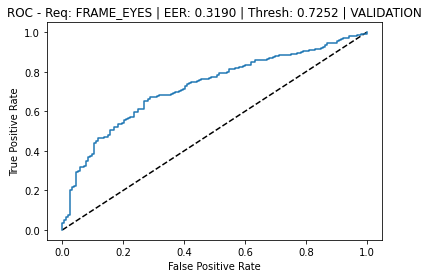

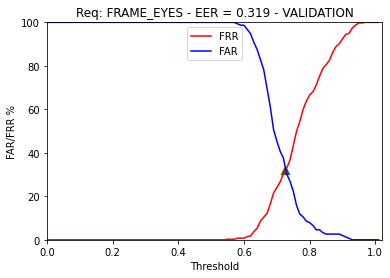

Requisite: FRAME_EYES - EER_interp: 31.900000000000002% - Best Threshold: 0.7251644492149353
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.45      0.68      0.54       152
    COMPLIANT       0.85      0.68      0.76       395

     accuracy                           0.68       547
    macro avg       0.65      0.68      0.65       547
 weighted avg       0.74      0.68      0.70       547

Confusion matrix ----------------------------------------
FAR: 31.580000000000002% | FRR: 31.900000000000002% | EER_mean: 31.740000000000002% | TP: 269 | TN: 104 | FP: 48 | FN: 126
Accuracy ------------------------------------------------
Model Accuracy: 68.19%
---------------------------------------------------------
Requisite: FLASH_LENSES


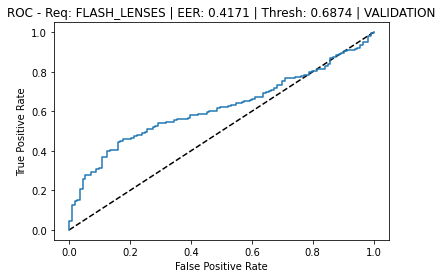

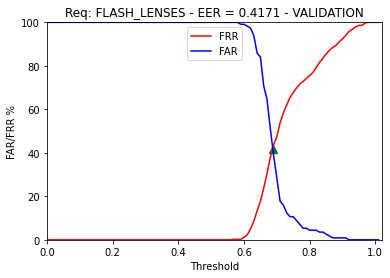

Requisite: FLASH_LENSES - EER_interp: 41.71% - Best Threshold: 0.6874239032718988
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.27      0.58      0.37       113
    COMPLIANT       0.84      0.58      0.69       434

     accuracy                           0.58       547
    macro avg       0.56      0.58      0.53       547
 weighted avg       0.72      0.58      0.62       547

Confusion matrix ----------------------------------------
FAR: 41.589999999999996% | FRR: 41.71% | EER_mean: 41.65% | TP: 253 | TN: 66 | FP: 47 | FN: 181
Accuracy ------------------------------------------------
Model Accuracy: 58.32000000000001%
---------------------------------------------------------
Requisite: VEIL


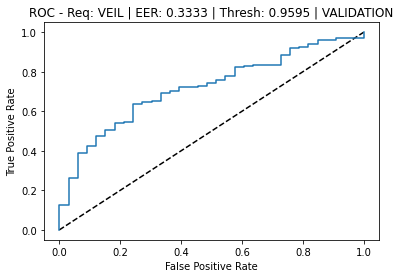

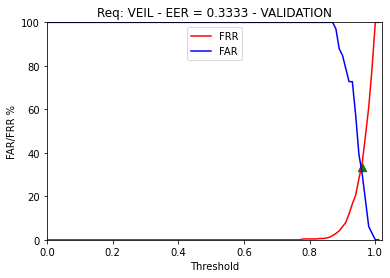

Requisite: VEIL - EER_interp: 33.33% - Best Threshold: 0.9595018625259415
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.11      0.67      0.19        33
    COMPLIANT       0.97      0.65      0.78       514

     accuracy                           0.65       547
    macro avg       0.54      0.66      0.48       547
 weighted avg       0.92      0.65      0.74       547

Confusion matrix ----------------------------------------
FAR: 33.33% | FRR: 35.02% | EER_mean: 34.18% | TP: 334 | TN: 22 | FP: 11 | FN: 180
Accuracy ------------------------------------------------
Model Accuracy: 65.08%
---------------------------------------------------------
Requisite: REFLECTION


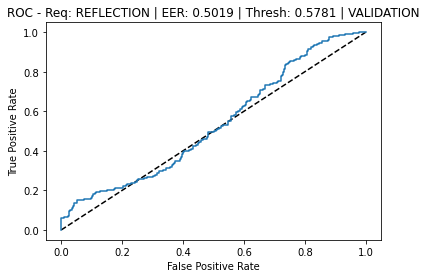

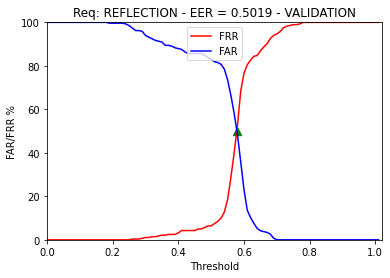

Requisite: REFLECTION - EER_interp: 50.19% - Best Threshold: 0.5780804157256356
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.48      0.50      0.49       265
    COMPLIANT       0.51      0.50      0.51       282

     accuracy                           0.50       547
    macro avg       0.50      0.50      0.50       547
 weighted avg       0.50      0.50      0.50       547

Confusion matrix ----------------------------------------
FAR: 50.19% | FRR: 50.0% | EER_mean: 50.1% | TP: 141 | TN: 132 | FP: 133 | FN: 141
Accuracy ------------------------------------------------
Model Accuracy: 49.91%
---------------------------------------------------------
Requisite: LIGHT


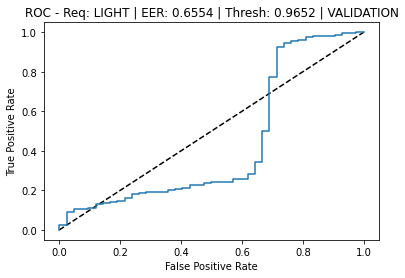

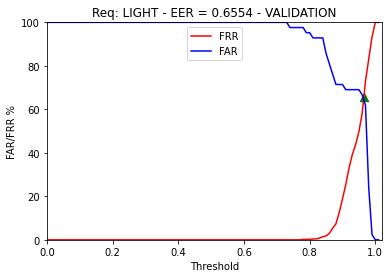

Requisite: LIGHT - EER_interp: 65.53999999999999% - Best Threshold: 0.9651797881220827
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.04      0.36      0.08        42
    COMPLIANT       0.87      0.34      0.49       505

     accuracy                           0.35       547
    macro avg       0.45      0.35      0.29       547
 weighted avg       0.80      0.35      0.46       547

Confusion matrix ----------------------------------------
FAR: 64.29% | FRR: 65.53999999999999% | EER_mean: 64.92% | TP: 174 | TN: 15 | FP: 27 | FN: 331
Accuracy ------------------------------------------------
Model Accuracy: 34.55%
---------------------------------------------------------
Requisite: SH_FACE


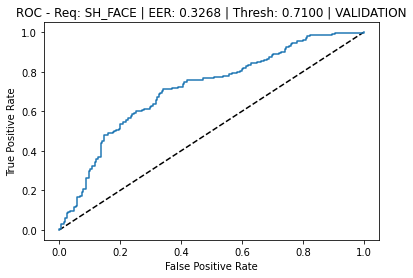

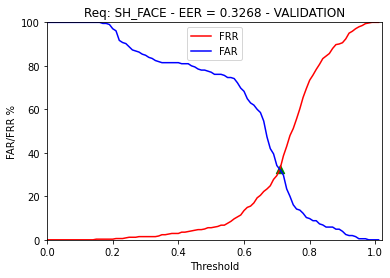

Requisite: SH_FACE - EER_interp: 32.68% - Best Threshold: 0.7099741101265851
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.67      0.61       205
    COMPLIANT       0.77      0.67      0.72       342

     accuracy                           0.67       547
    macro avg       0.66      0.67      0.66       547
 weighted avg       0.69      0.67      0.68       547

Confusion matrix ----------------------------------------
FAR: 32.68% | FRR: 32.75% | EER_mean: 32.72% | TP: 230 | TN: 138 | FP: 67 | FN: 112
Accuracy ------------------------------------------------
Model Accuracy: 67.28%
---------------------------------------------------------
Requisite: SH_HEAD


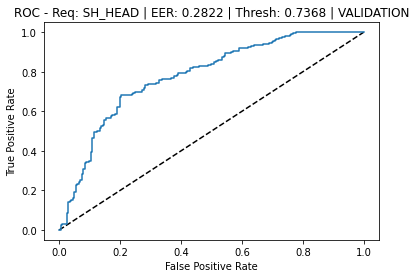

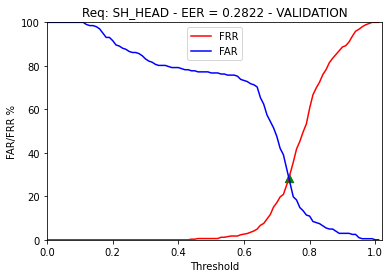

Requisite: SH_HEAD - EER_interp: 28.22% - Best Threshold: 0.7367938160896325
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.60      0.72      0.65       202
    COMPLIANT       0.81      0.72      0.76       345

     accuracy                           0.72       547
    macro avg       0.70      0.72      0.71       547
 weighted avg       0.73      0.72      0.72       547

Confusion matrix ----------------------------------------
FAR: 28.22% | FRR: 28.410000000000004% | EER_mean: 28.32% | TP: 247 | TN: 145 | FP: 57 | FN: 98
Accuracy ------------------------------------------------
Model Accuracy: 71.66%
---------------------------------------------------------
Requisite: BLURRED


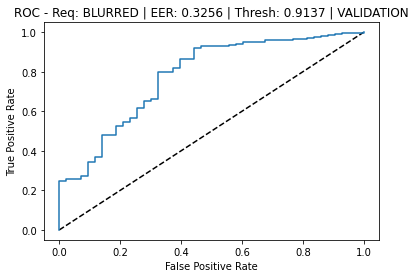

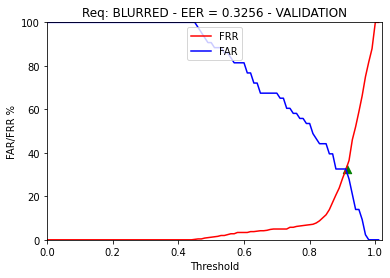

Requisite: BLURRED - EER_interp: 32.56% - Best Threshold: 0.913745224475863
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.14      0.67      0.24        43
    COMPLIANT       0.96      0.66      0.78       504

     accuracy                           0.66       547
    macro avg       0.55      0.67      0.51       547
 weighted avg       0.90      0.66      0.74       547

Confusion matrix ----------------------------------------
FAR: 32.56% | FRR: 33.93% | EER_mean: 33.25% | TP: 333 | TN: 29 | FP: 14 | FN: 171
Accuracy ------------------------------------------------
Model Accuracy: 66.18%
---------------------------------------------------------
Requisite: SKIN_TONE


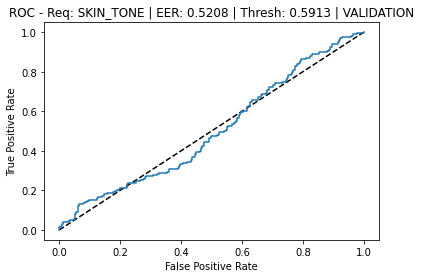

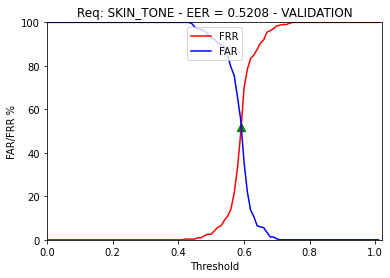

Requisite: SKIN_TONE - EER_interp: 52.080000000000005% - Best Threshold: 0.5913212217461948
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.41      0.48      0.44       234
    COMPLIANT       0.55      0.48      0.51       313

     accuracy                           0.48       547
    macro avg       0.48      0.48      0.48       547
 weighted avg       0.49      0.48      0.48       547

Confusion matrix ----------------------------------------
FAR: 52.14% | FRR: 52.080000000000005% | EER_mean: 52.11% | TP: 150 | TN: 112 | FP: 122 | FN: 163
Accuracy ------------------------------------------------
Model Accuracy: 47.9%
---------------------------------------------------------
Requisite: WASHED_OUT


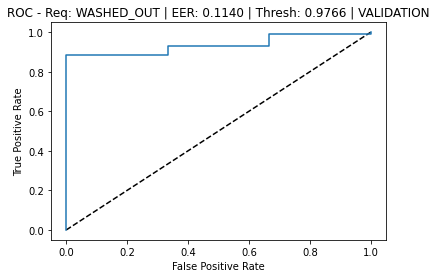

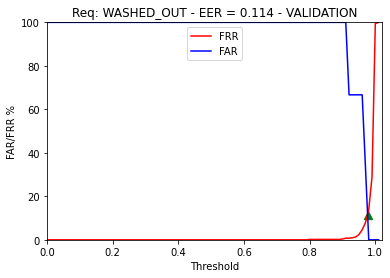

Requisite: WASHED_OUT - EER_interp: 11.4% - Best Threshold: 0.9765516931519789
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.05      1.00      0.09         3
    COMPLIANT       1.00      0.89      0.94       544

     accuracy                           0.89       547
    macro avg       0.52      0.94      0.51       547
 weighted avg       0.99      0.89      0.93       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 11.4% | EER_mean: 5.7% | TP: 482 | TN: 3 | FP: 0 | FN: 62
Accuracy ------------------------------------------------
Model Accuracy: 88.67%
---------------------------------------------------------
Requisite: PIXELATION


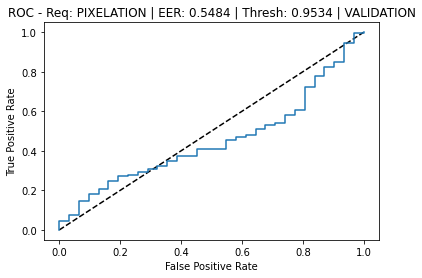

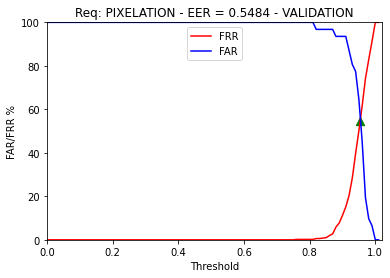

Requisite: PIXELATION - EER_interp: 54.84% - Best Threshold: 0.9534162282943722
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.05      0.45      0.09        31
    COMPLIANT       0.93      0.46      0.61       516

     accuracy                           0.46       547
    macro avg       0.49      0.45      0.35       547
 weighted avg       0.88      0.46      0.58       547

Confusion matrix ----------------------------------------
FAR: 54.84% | FRR: 54.459999999999994% | EER_mean: 54.65% | TP: 235 | TN: 14 | FP: 17 | FN: 281
Accuracy ------------------------------------------------
Model Accuracy: 45.519999999999996%
---------------------------------------------------------
Requisite: HAIR_EYES


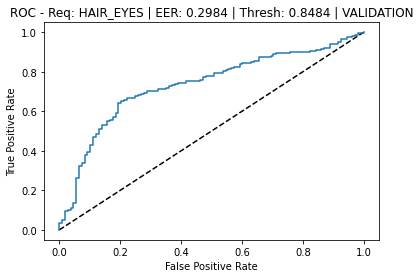

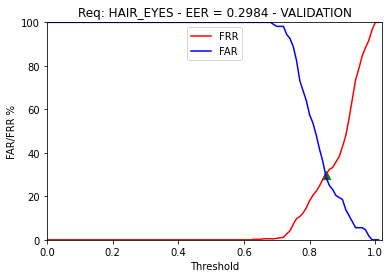

Requisite: HAIR_EYES - EER_interp: 29.84% - Best Threshold: 0.8483904105475224
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.37      0.71      0.49       108
    COMPLIANT       0.91      0.70      0.79       439

     accuracy                           0.70       547
    macro avg       0.64      0.71      0.64       547
 weighted avg       0.80      0.70      0.73       547

Confusion matrix ----------------------------------------
FAR: 28.7% | FRR: 29.84% | EER_mean: 29.270000000000003% | TP: 308 | TN: 77 | FP: 31 | FN: 131
Accuracy ------------------------------------------------
Model Accuracy: 70.38%
---------------------------------------------------------
Requisite: BACKGROUND


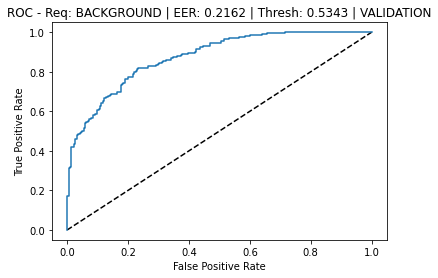

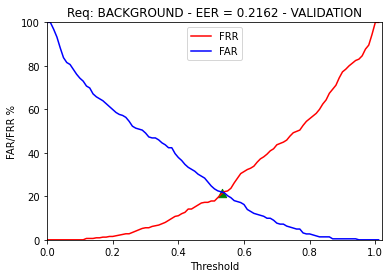

Requisite: BACKGROUND - EER_interp: 21.62% - Best Threshold: 0.5343260765075473
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.72      0.78      0.75       222
    COMPLIANT       0.84      0.79      0.81       325

     accuracy                           0.79       547
    macro avg       0.78      0.79      0.78       547
 weighted avg       0.79      0.79      0.79       547

Confusion matrix ----------------------------------------
FAR: 21.62% | FRR: 21.23% | EER_mean: 21.42% | TP: 256 | TN: 174 | FP: 48 | FN: 69
Accuracy ------------------------------------------------
Model Accuracy: 78.61%
---------------------------------------------------------
Requisite: RED_EYES


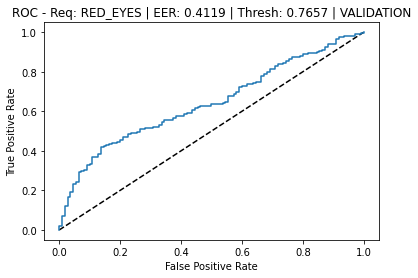

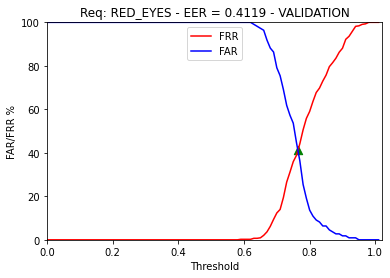

Requisite: RED_EYES - EER_interp: 41.19% - Best Threshold: 0.7657322096606411
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.27      0.59      0.37       110
    COMPLIANT       0.85      0.59      0.70       437

     accuracy                           0.59       547
    macro avg       0.56      0.59      0.53       547
 weighted avg       0.73      0.59      0.63       547

Confusion matrix ----------------------------------------
FAR: 40.910000000000004% | FRR: 41.19% | EER_mean: 41.05% | TP: 257 | TN: 65 | FP: 45 | FN: 180
Accuracy ------------------------------------------------
Model Accuracy: 58.87%
---------------------------------------------------------
final_EER_mean: 36.32% | final_ACC: 62.85%


In [22]:
runner.set_model_evaluator_data_src(DataSource.VALIDATION)
runner.test_model()

## Test Split

Testing Trained Model
Predicting labels....
9/9 [==============================] - 24s 3s/step
Prediction finished!
Requisite: MOUTH


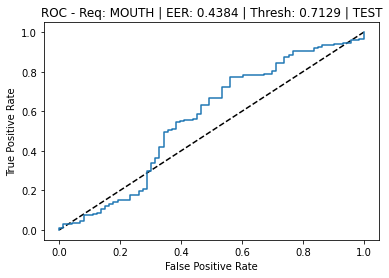

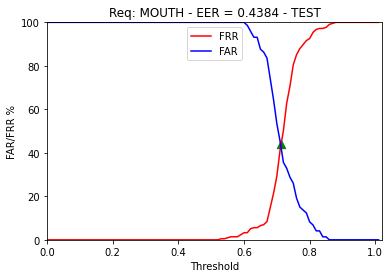

Requisite: MOUTH - EER_interp: 43.84% - Best Threshold: 0.7129148840903904
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.30      0.56      0.39        73
    COMPLIANT       0.79      0.56      0.66       215

     accuracy                           0.56       288
    macro avg       0.55      0.56      0.53       288
 weighted avg       0.67      0.56      0.59       288

Confusion matrix ----------------------------------------
FAR: 43.84% | FRR: 43.72% | EER_mean: 43.78% | TP: 121 | TN: 41 | FP: 32 | FN: 94
Accuracy ------------------------------------------------
Model Accuracy: 56.25%
---------------------------------------------------------
Requisite: ROTATION


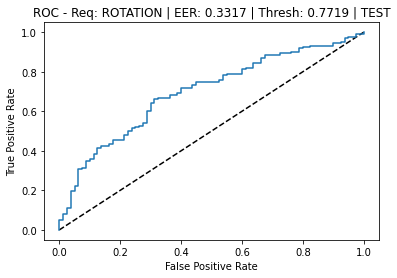

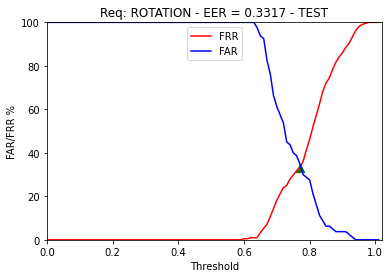

Requisite: ROTATION - EER_interp: 33.17% - Best Threshold: 0.7719359993934631
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.43      0.66      0.52        80
    COMPLIANT       0.84      0.67      0.74       208

     accuracy                           0.67       288
    macro avg       0.64      0.67      0.63       288
 weighted avg       0.73      0.67      0.68       288

Confusion matrix ----------------------------------------
FAR: 33.75% | FRR: 33.17% | EER_mean: 33.46% | TP: 139 | TN: 53 | FP: 27 | FN: 69
Accuracy ------------------------------------------------
Model Accuracy: 66.67%
---------------------------------------------------------
Requisite: L_AWAY


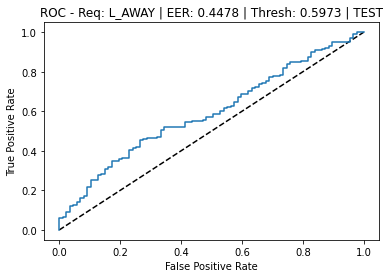

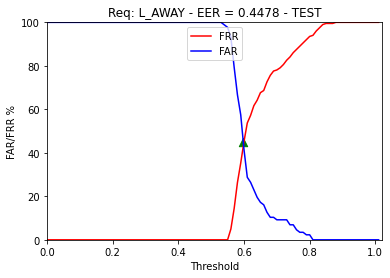

Requisite: L_AWAY - EER_interp: 44.78% - Best Threshold: 0.5972674981278463
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.35      0.55      0.43        87
    COMPLIANT       0.74      0.55      0.63       201

     accuracy                           0.55       288
    macro avg       0.54      0.55      0.53       288
 weighted avg       0.62      0.55      0.57       288

Confusion matrix ----------------------------------------
FAR: 44.83% | FRR: 44.78% | EER_mean: 44.800000000000004% | TP: 111 | TN: 48 | FP: 39 | FN: 90
Accuracy ------------------------------------------------
Model Accuracy: 55.21%
---------------------------------------------------------
Requisite: EYES_CLOSED


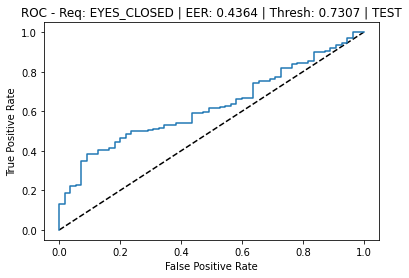

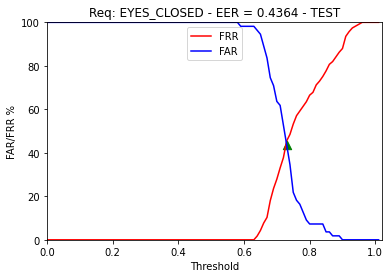

Requisite: EYES_CLOSED - EER_interp: 43.64% - Best Threshold: 0.7307264208793747
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.22      0.56      0.32        55
    COMPLIANT       0.84      0.54      0.66       233

     accuracy                           0.55       288
    macro avg       0.53      0.55      0.49       288
 weighted avg       0.72      0.55      0.59       288

Confusion matrix ----------------------------------------
FAR: 43.64% | FRR: 45.92% | EER_mean: 44.78% | TP: 126 | TN: 31 | FP: 24 | FN: 107
Accuracy ------------------------------------------------
Model Accuracy: 54.510000000000005%
---------------------------------------------------------
Requisite: CLOSE


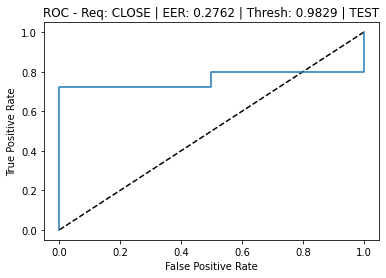

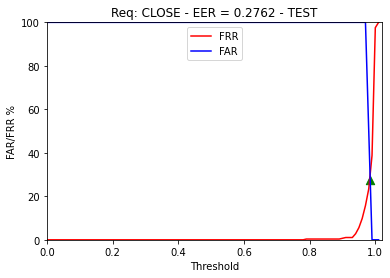

Requisite: CLOSE - EER_interp: 27.62% - Best Threshold: 0.982894587766874
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.02      1.00      0.05         2
    COMPLIANT       1.00      0.72      0.84       286

     accuracy                           0.73       288
    macro avg       0.51      0.86      0.44       288
 weighted avg       0.99      0.73      0.83       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 27.62% | EER_mean: 13.81% | TP: 207 | TN: 2 | FP: 0 | FN: 79
Accuracy ------------------------------------------------
Model Accuracy: 72.57000000000001%
---------------------------------------------------------
Requisite: HAT


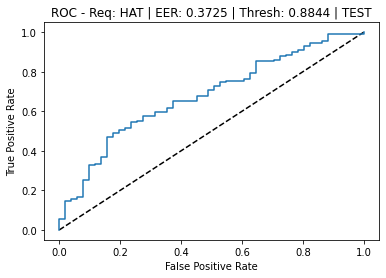

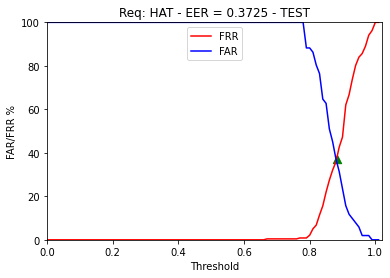

Requisite: HAT - EER_interp: 37.25% - Best Threshold: 0.8843873143196287
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.26      0.63      0.37        51
    COMPLIANT       0.88      0.62      0.73       237

     accuracy                           0.62       288
    macro avg       0.57      0.62      0.55       288
 weighted avg       0.77      0.62      0.66       288

Confusion matrix ----------------------------------------
FAR: 37.25% | FRR: 38.4% | EER_mean: 37.82% | TP: 146 | TN: 32 | FP: 19 | FN: 91
Accuracy ------------------------------------------------
Model Accuracy: 61.809999999999995%
---------------------------------------------------------
Requisite: DARK_GLASSES


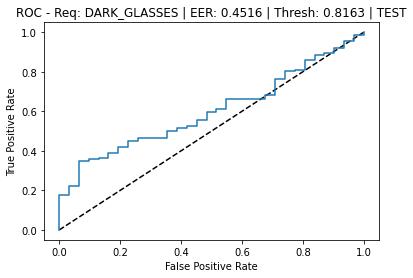

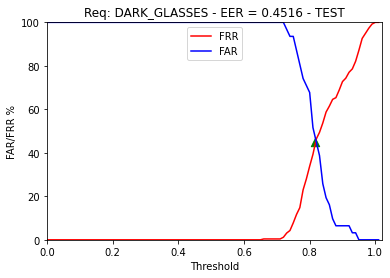

Requisite: DARK_GLASSES - EER_interp: 45.16% - Best Threshold: 0.816340208053588
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.13      0.55      0.21        31
    COMPLIANT       0.91      0.56      0.69       257

     accuracy                           0.56       288
    macro avg       0.52      0.55      0.45       288
 weighted avg       0.83      0.56      0.64       288

Confusion matrix ----------------------------------------
FAR: 45.16% | FRR: 44.36% | EER_mean: 44.76% | TP: 143 | TN: 17 | FP: 14 | FN: 114
Accuracy ------------------------------------------------
Model Accuracy: 55.559999999999995%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


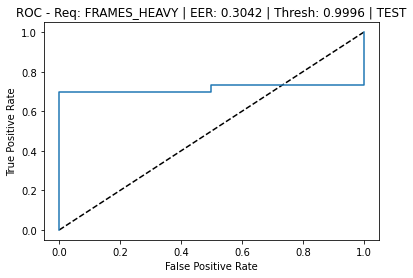

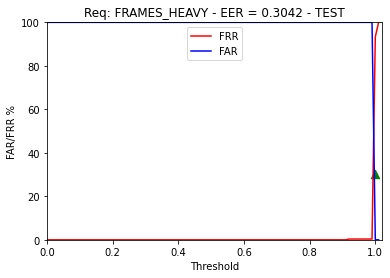

Requisite: FRAMES_HEAVY - EER_interp: 30.42% - Best Threshold: 0.999641145859565
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.02      1.00      0.04         2
    COMPLIANT       1.00      0.70      0.82       286

     accuracy                           0.70       288
    macro avg       0.51      0.85      0.43       288
 weighted avg       0.99      0.70      0.82       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 30.42% | EER_mean: 15.21% | TP: 199 | TN: 2 | FP: 0 | FN: 87
Accuracy ------------------------------------------------
Model Accuracy: 69.78999999999999%
---------------------------------------------------------
Requisite: FRAME_EYES


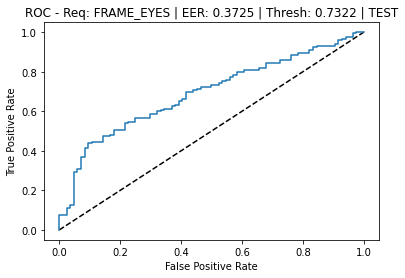

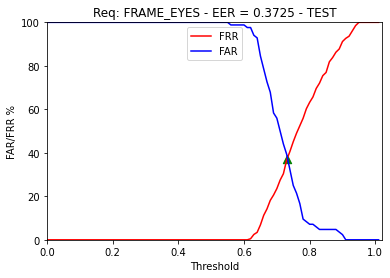

Requisite: FRAME_EYES - EER_interp: 37.25% - Best Threshold: 0.7322373285013087
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.41      0.63      0.50        84
    COMPLIANT       0.81      0.63      0.71       204

     accuracy                           0.63       288
    macro avg       0.61      0.63      0.60       288
 weighted avg       0.69      0.63      0.64       288

Confusion matrix ----------------------------------------
FAR: 36.9% | FRR: 37.25% | EER_mean: 37.08% | TP: 128 | TN: 53 | FP: 31 | FN: 76
Accuracy ------------------------------------------------
Model Accuracy: 62.849999999999994%
---------------------------------------------------------
Requisite: FLASH_LENSES


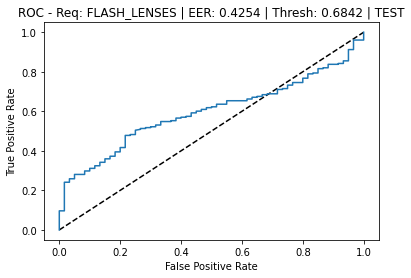

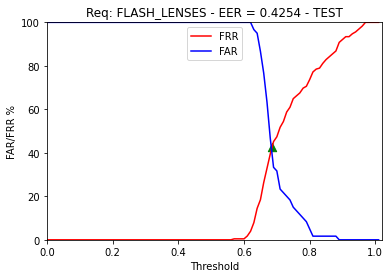

Requisite: FLASH_LENSES - EER_interp: 42.54% - Best Threshold: 0.6841515145803672
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.27      0.58      0.36        60
    COMPLIANT       0.84      0.57      0.68       228

     accuracy                           0.58       288
    macro avg       0.55      0.58      0.52       288
 weighted avg       0.72      0.58      0.62       288

Confusion matrix ----------------------------------------
FAR: 41.67% | FRR: 42.54% | EER_mean: 42.1% | TP: 131 | TN: 35 | FP: 25 | FN: 97
Accuracy ------------------------------------------------
Model Accuracy: 57.64%
---------------------------------------------------------
Requisite: VEIL


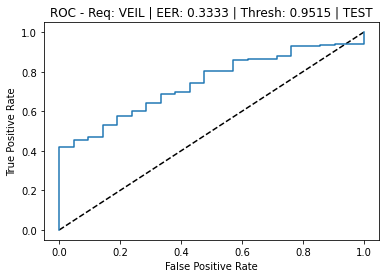

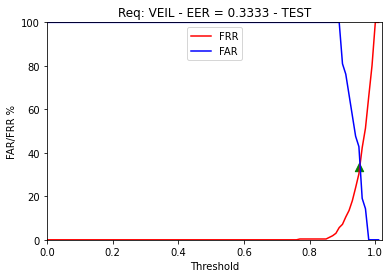

Requisite: VEIL - EER_interp: 33.33% - Best Threshold: 0.9514598846435378
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.14      0.67      0.24        21
    COMPLIANT       0.96      0.69      0.80       267

     accuracy                           0.68       288
    macro avg       0.55      0.68      0.52       288
 weighted avg       0.90      0.68      0.76       288

Confusion matrix ----------------------------------------
FAR: 33.33% | FRR: 31.46% | EER_mean: 32.39% | TP: 183 | TN: 14 | FP: 7 | FN: 84
Accuracy ------------------------------------------------
Model Accuracy: 68.4%
---------------------------------------------------------
Requisite: REFLECTION


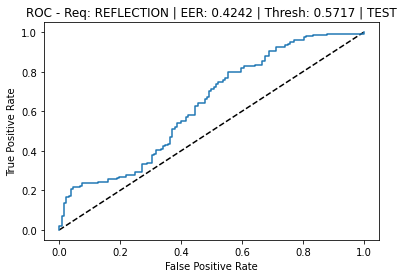

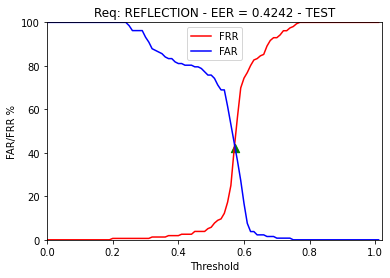

Requisite: REFLECTION - EER_interp: 42.42% - Best Threshold: 0.571671783924118
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.53      0.58      0.55       132
    COMPLIANT       0.61      0.57      0.59       156

     accuracy                           0.57       288
    macro avg       0.57      0.57      0.57       288
 weighted avg       0.58      0.57      0.57       288

Confusion matrix ----------------------------------------
FAR: 42.42% | FRR: 42.95% | EER_mean: 42.68% | TP: 89 | TN: 76 | FP: 56 | FN: 67
Accuracy ------------------------------------------------
Model Accuracy: 57.29%
---------------------------------------------------------
Requisite: LIGHT


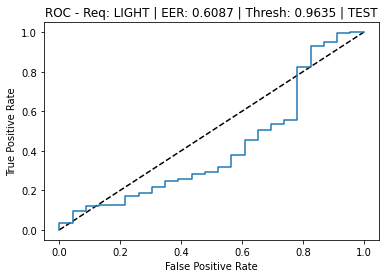

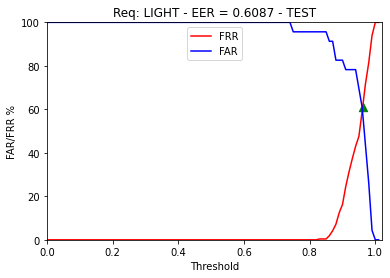

Requisite: LIGHT - EER_interp: 60.870000000000005% - Best Threshold: 0.963464200496676
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.05      0.39      0.09        23
    COMPLIANT       0.88      0.38      0.53       265

     accuracy                           0.38       288
    macro avg       0.46      0.38      0.31       288
 weighted avg       0.81      0.38      0.49       288

Confusion matrix ----------------------------------------
FAR: 60.870000000000005% | FRR: 62.260000000000005% | EER_mean: 61.56% | TP: 100 | TN: 9 | FP: 14 | FN: 165
Accuracy ------------------------------------------------
Model Accuracy: 37.85%
---------------------------------------------------------
Requisite: SH_FACE


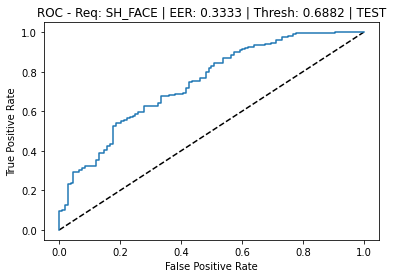

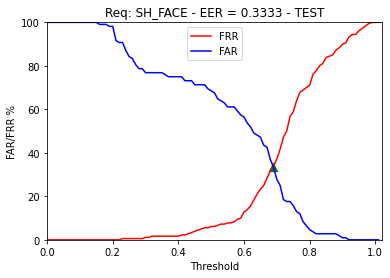

Requisite: SH_FACE - EER_interp: 33.33% - Best Threshold: 0.6881700158118934
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.67      0.61       108
    COMPLIANT       0.77      0.68      0.72       180

     accuracy                           0.67       288
    macro avg       0.66      0.67      0.66       288
 weighted avg       0.69      0.67      0.68       288

Confusion matrix ----------------------------------------
FAR: 33.33% | FRR: 32.22% | EER_mean: 32.78% | TP: 122 | TN: 72 | FP: 36 | FN: 58
Accuracy ------------------------------------------------
Model Accuracy: 67.36%
---------------------------------------------------------
Requisite: SH_HEAD


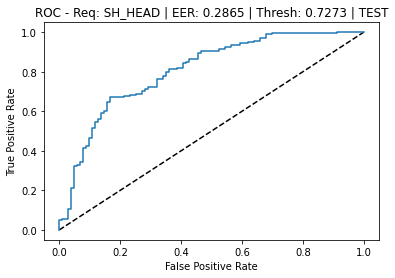

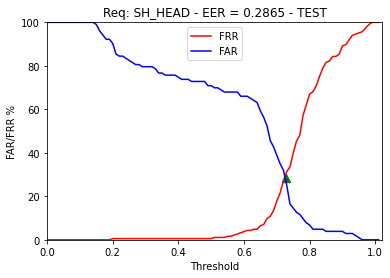

Requisite: SH_HEAD - EER_interp: 28.65% - Best Threshold: 0.7273076386065096
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.58      0.72      0.64       103
    COMPLIANT       0.82      0.71      0.76       185

     accuracy                           0.72       288
    macro avg       0.70      0.72      0.70       288
 weighted avg       0.74      0.72      0.72       288

Confusion matrix ----------------------------------------
FAR: 28.16% | FRR: 28.65% | EER_mean: 28.410000000000004% | TP: 132 | TN: 74 | FP: 29 | FN: 53
Accuracy ------------------------------------------------
Model Accuracy: 71.53%
---------------------------------------------------------
Requisite: BLURRED


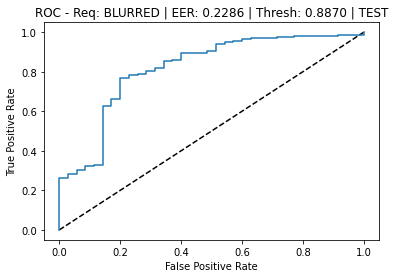

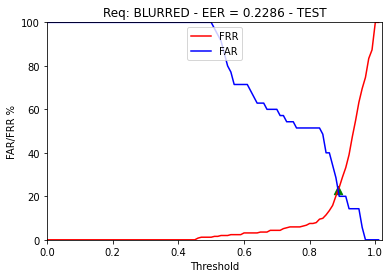

Requisite: BLURRED - EER_interp: 22.86% - Best Threshold: 0.8870189189911059
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.32      0.77      0.45        35
    COMPLIANT       0.96      0.77      0.86       253

     accuracy                           0.77       288
    macro avg       0.64      0.77      0.65       288
 weighted avg       0.88      0.77      0.81       288

Confusion matrix ----------------------------------------
FAR: 22.86% | FRR: 22.919999999999998% | EER_mean: 22.89% | TP: 195 | TN: 27 | FP: 8 | FN: 58
Accuracy ------------------------------------------------
Model Accuracy: 77.08%
---------------------------------------------------------
Requisite: SKIN_TONE


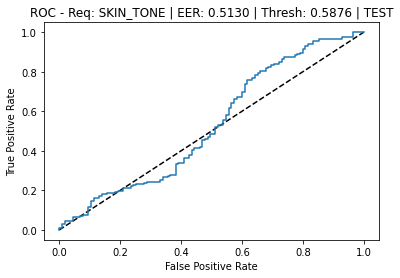

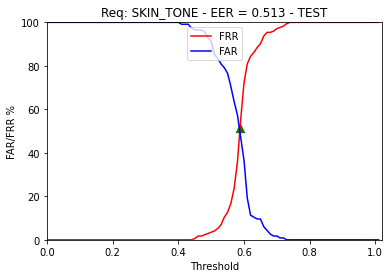

Requisite: SKIN_TONE - EER_interp: 51.300000000000004% - Best Threshold: 0.5876139998436138
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.39      0.49      0.43       115
    COMPLIANT       0.59      0.49      0.53       173

     accuracy                           0.49       288
    macro avg       0.49      0.49      0.48       288
 weighted avg       0.51      0.49      0.49       288

Confusion matrix ----------------------------------------
FAR: 51.300000000000004% | FRR: 51.449999999999996% | EER_mean: 51.370000000000005% | TP: 84 | TN: 56 | FP: 59 | FN: 89
Accuracy ------------------------------------------------
Model Accuracy: 48.61%
---------------------------------------------------------
Requisite: WASHED_OUT


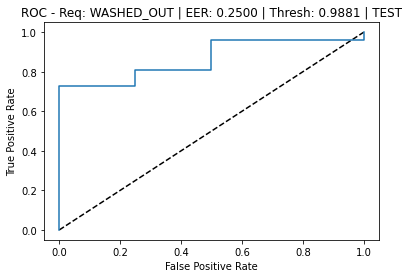

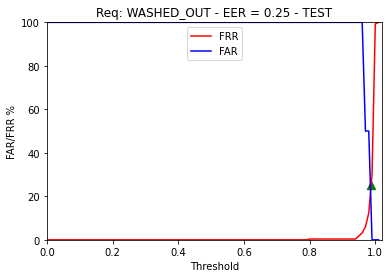

Requisite: WASHED_OUT - EER_interp: 25.0% - Best Threshold: 0.9880560636520391
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.04      0.75      0.07         4
    COMPLIANT       1.00      0.73      0.84       284

     accuracy                           0.73       288
    macro avg       0.52      0.74      0.46       288
 weighted avg       0.98      0.73      0.83       288

Confusion matrix ----------------------------------------
FAR: 25.0% | FRR: 27.11% | EER_mean: 26.06% | TP: 207 | TN: 3 | FP: 1 | FN: 77
Accuracy ------------------------------------------------
Model Accuracy: 72.92%
---------------------------------------------------------
Requisite: PIXELATION


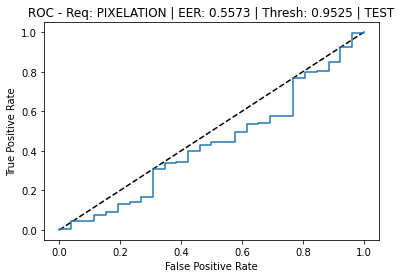

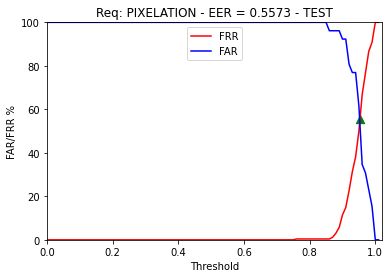

Requisite: PIXELATION - EER_interp: 55.730000000000004% - Best Threshold: 0.9524766898337211
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.08      0.46      0.13        26
    COMPLIANT       0.89      0.44      0.59       262

     accuracy                           0.44       288
    macro avg       0.48      0.45      0.36       288
 weighted avg       0.82      0.44      0.55       288

Confusion matrix ----------------------------------------
FAR: 53.849999999999994% | FRR: 55.730000000000004% | EER_mean: 54.790000000000006% | TP: 116 | TN: 12 | FP: 14 | FN: 146
Accuracy ------------------------------------------------
Model Accuracy: 44.440000000000005%
---------------------------------------------------------
Requisite: HAIR_EYES


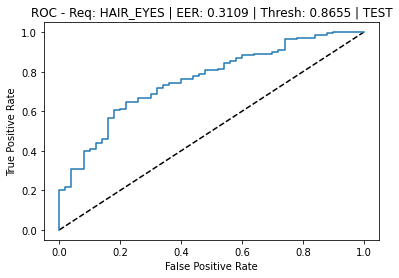

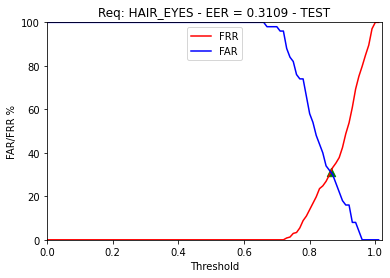

Requisite: HAIR_EYES - EER_interp: 31.09% - Best Threshold: 0.8655073046684256
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.32      0.70      0.44        50
    COMPLIANT       0.92      0.69      0.79       238

     accuracy                           0.69       288
    macro avg       0.62      0.69      0.61       288
 weighted avg       0.81      0.69      0.73       288

Confusion matrix ----------------------------------------
FAR: 30.0% | FRR: 31.09% | EER_mean: 30.54% | TP: 164 | TN: 35 | FP: 15 | FN: 74
Accuracy ------------------------------------------------
Model Accuracy: 69.1%
---------------------------------------------------------
Requisite: BACKGROUND


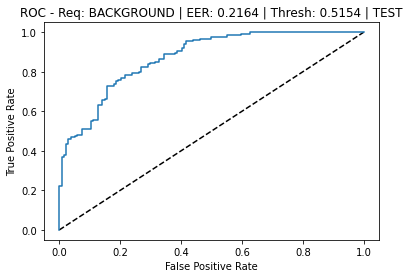

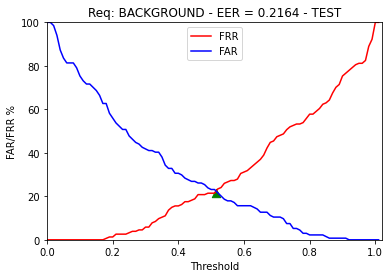

Requisite: BACKGROUND - EER_interp: 21.64% - Best Threshold: 0.515396714209594
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.76      0.78      0.77       134
    COMPLIANT       0.81      0.79      0.80       154

     accuracy                           0.78       288
    macro avg       0.78      0.78      0.78       288
 weighted avg       0.79      0.78      0.78       288

Confusion matrix ----------------------------------------
FAR: 21.64% | FRR: 21.43% | EER_mean: 21.54% | TP: 121 | TN: 105 | FP: 29 | FN: 33
Accuracy ------------------------------------------------
Model Accuracy: 78.47%
---------------------------------------------------------
Requisite: RED_EYES


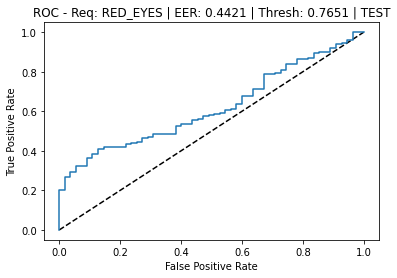

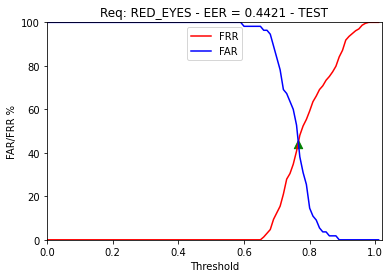

Requisite: RED_EYES - EER_interp: 44.21% - Best Threshold: 0.7650816509652035
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.23      0.56      0.33        55
    COMPLIANT       0.84      0.56      0.67       233

     accuracy                           0.56       288
    macro avg       0.54      0.56      0.50       288
 weighted avg       0.73      0.56      0.61       288

Confusion matrix ----------------------------------------
FAR: 43.64% | FRR: 44.21% | EER_mean: 43.919999999999995% | TP: 130 | TN: 31 | FP: 24 | FN: 103
Accuracy ------------------------------------------------
Model Accuracy: 55.900000000000006%
---------------------------------------------------------
final_EER_mean: 36.66% | final_ACC: 61.9%


In [23]:
runner.set_model_evaluator_data_src(DataSource.TEST)
runner.test_model()

# Visualize Model Classification

# Finishing Experiment Manager

In [24]:
runner.finish_experiment()

-------------------- finish experiment -------------------
Not using Neptune


# Testing Network Modification

# Test - Customized Loss Function

# Test - 

In [6]:
import tensorflow as tf
import numpy as np

import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


def __create_rnn_model():
    model = Sequential([
        Dense(4, activation="relu"),
        Dense(64, activation="relu"),
        Dense(4, activation="softmax")
    ])

    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

    return model

def __preprocess_config(config):
    return np.linalg.norm(config)
    


np.random.seed(2)

X = np.random.rand(400,4)
y = np.random.rand(400,4)

# X = tf.expand_dims(X, axis=0)
# y = np.expand_dims(y, axis=0)

print(X.shape)
print(y.shape)

X_test = np.random.rand(20,4)
y_test = np.random.rand(20,4)

# X_test = tf.expand_dims(X_test, axis=0)
# y_test = tf.expand_dims(y_test, axis=0)

m = __create_rnn_model()

m.fit(X,y, batch_size=32, epochs=5)

loss, acc = m.evaluate(X_test,y_test, batch_size=32)

print(f'loss: {loss}%')
print(f'acc: {round(acc*100,2)}%')

print(f'prediction: {m.predict(np.array(X_test[0]).reshape(1,4))}')

(400, 4)
(400, 4)


2021-10-13 22:08:05.152044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-13 22:08:05.170813: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3599960000 Hz


Epoch 1/5


2021-10-13 22:08:05.423261: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


13/13 [==============================] - 1s 2ms/step - loss: 2.7712 - accuracy: 0.2250
Epoch 2/5
13/13 [==============================] - 0s 1ms/step - loss: 2.7745 - accuracy: 0.2300
Epoch 3/5
13/13 [==============================] - 0s 1ms/step - loss: 2.7779 - accuracy: 0.2275
Epoch 4/5
13/13 [==============================] - 0s 1ms/step - loss: 2.7834 - accuracy: 0.2250
Epoch 5/5
13/13 [==============================] - 0s 1ms/step - loss: 2.7878 - accuracy: 0.2225


2021-10-13 22:08:06.178882: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1/1 [==============================] - 0s 84ms/step - loss: 2.5637 - accuracy: 0.1500
loss: 2.563713788986206%
acc: 15.0%
prediction: [[0.27274007 0.28207222 0.20936829 0.23581944]]


In [7]:
import sys
import random

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Embedding, LSTM, LSTMCell, RNN, Reshape
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomUniform, HeNormal, GlorotNormal

import tensorflow as tf


def get_weight_initializer(initializer=None, seed=None):
    if initializer is None:
        return HeNormal()
    elif initializer == "lstm":
        return RandomUniform(minval=-0.1, maxval=0.1)
    else:
        return GlorotNormal()


def get_weight_regularizer(regularizer=None, rate=1e-4):
    if regularizer is None:
        return regularizers.l2(rate)
    else:
        return regularizer(rate)


class ControllerRNNController(object):
    def __init__(self,
                 controller_network_name,
                 num_nodes,
                 num_opers,
                 input_x,
                 reward=0,
                 temperature=5.0,
                 tanh_constant=2.5,
                 model_file=None,
                 lstm_cell_units=32,
                 baseline_decay=0.999,
                 opt=Adam(learning_rate=0.00035, decay=1e-3, amsgrad=True)):

        self.controller_network_name = controller_network_name
        self.num_nodes = num_nodes
        self.num_opers = num_opers
        self.reward = reward
        self.input_x = input_x
        self.temperature = temperature
        self.tanh_constant = tanh_constant
        self.lstm_cell_units = lstm_cell_units
        self.opt = opt
        self.model_file = model_file

        self.controller_rnn = self.generate_controller_rnn()
        self.baseline = None
        self.baseline_decay = baseline_decay

        #self.graph = tf.get_default_graph()

    def lstm_reshape(self,
                     inputs,
                     name_prefix,
                     index,
                     reshaped_inputs=None,
                     initial=False):
        name_prefix = "{0}_{1}_{2}".format(self.controller_network_name,
                                           name_prefix, index)
        cell = LSTMCell(
            self.lstm_cell_units,
            kernel_initializer=get_weight_initializer(initializer="lstm"),
            recurrent_initializer=get_weight_initializer(initializer="lstm"))
        if initial:
            x = RNN(
                cell,
                return_state=True,
                name="{0}_{1}".format(name_prefix, "lstm"))(inputs)
        else:
            x = RNN(
                cell,
                return_state=True,
                name="{0}_{1}".format(name_prefix, "lstm"))(
                    reshaped_inputs, initial_state=inputs[1:])
        rx = Reshape(
            (-1, self.lstm_cell_units),
            name="{0}_{1}".format(name_prefix, "reshape"))(x[0])
        return x, rx

    def dense_softmax(self, inputs, num_classes, name_prefix, index):
        name_prefix = "{0}_{1}_{2}".format(self.controller_network_name,
                                           name_prefix, index)
        y = Dense(
            num_classes, name="{0}_{1}".format(name_prefix, "dense"))(inputs)
        y = Activation(
            activation="softmax",
            name="{0}_{1}".format(name_prefix, "softmax"))(y)
        return y

    def generate_controller_rnn(self):
        outputs = []
        controller_input = Input(shape=(1, 1,), name="{0}_{1}".format(self.controller_network_name, "input"))

        for i in range(2, self.num_nodes):
            for o in ["inputL", "inputR", "operL", "operR"]:
                if i == 2 and o == "inputL":
                    _x, _rx, _initial = controller_input, None, True
                else:
                    _x, _rx, _initial = x, rx, False

                if o in ["inputL", "inputR"]:
                    _num_classes = i
                else:
                    _num_classes = self.num_opers

                x, rx = self.lstm_reshape(
                    inputs=_x,
                    name_prefix=o,
                    index=i,
                    reshaped_inputs=_rx,
                    initial=_initial)
                y = self.dense_softmax(
                    inputs=x[0],
                    num_classes=_num_classes,
                    name_prefix=o,
                    index=i)
                outputs.append(y)

        controller_rnn = Model(inputs=controller_input, outputs=outputs)

        if self.model_file is not None and os.path.exists(self.model_file):
            controller_rnn.load_weights(self.model_file)
        return controller_rnn

    def compile_controller_rnn(self):
        def _controller_loss(y_true, y_pred):
            if self.baseline is None:
                self.baseline = 0
            else:
                self.baseline -= (1 - self.baseline_decay) * (self.baseline - self.reward)
            return y_pred * (self.reward - self.baseline)

        def _define_loss(controller_loss):
            outputs_loss = {}
            for i in range(2, self.num_nodes):
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "inputL", i, "softmax")] = controller_loss
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "inputR", i, "softmax")] = controller_loss
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "operL", i, "softmax")] = controller_loss
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "operR", i, "softmax")] = controller_loss
            return outputs_loss

        self.controller_rnn.compile(loss=_define_loss(_controller_loss), optimizer=self.opt)

    def save_model(self):
        self.controller_rnn.save_weights(self.model_file)

    def train_controller_rnn(self,
                             targets,
                             batch_size=1,
                             epochs=50,
                             callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')]):
        #with self.graph.as_default():
        self.compile_controller_rnn()
        self.controller_rnn.fit(
            self.input_x,
            targets,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0)

    def softmax_predict(self):
        #with self.graph.as_default():
        self.compile_controller_rnn()
        return self.controller_rnn.predict(self.input_x)

    def random_sample_softmax(self, controller_pred):
        sample_softmax = []
        for cp in controller_pred:
            cp /= self.temperature
            cp = self.tanh_constant * np.tanh(cp)
            cp = np.exp(cp) / np.sum(np.exp(cp))
            cp = np.array([np.random.multinomial(1, cp[0])])
            sample_softmax.append(cp)
        return sample_softmax

    def convert_pred_to_cell(self, controller_pred):
        cell_pred = {}
        for p in range(2, self.num_nodes):
            pos = list(range((p - 2) * 4, ((p - 2) * 4) + 4))
            cell_pred[p] = {
                "L": {
                    "input_layer": np.argmax(controller_pred[pos[0]]),
                    "oper_id": np.argmax(controller_pred[pos[2]])
                },
                "R": {
                    "input_layer": np.argmax(controller_pred[pos[1]]),
                    "oper_id": np.argmax(controller_pred[pos[3]])
                }
            }
        return cell_pred

    def convert_pred_to_ydict(self, controller_pred):
        ydict = {}
        name_prefix = self.controller_network_name
        for i in range(2, self.num_nodes):
            pos = list(range((i - 2) * 4, ((i - 2) * 4) + 4))
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "inputL", i, "softmax")] = controller_pred[pos[0]]
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "inputR", i, "softmax")] = controller_pred[pos[1]]
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "operL", i, "softmax")] = controller_pred[pos[2]]
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "operR", i, "softmax")] = controller_pred[pos[3]]
        return ydict


In [8]:
contr = ControllerRNNController("netname", num_nodes=3, num_opers=3, input_x=X)

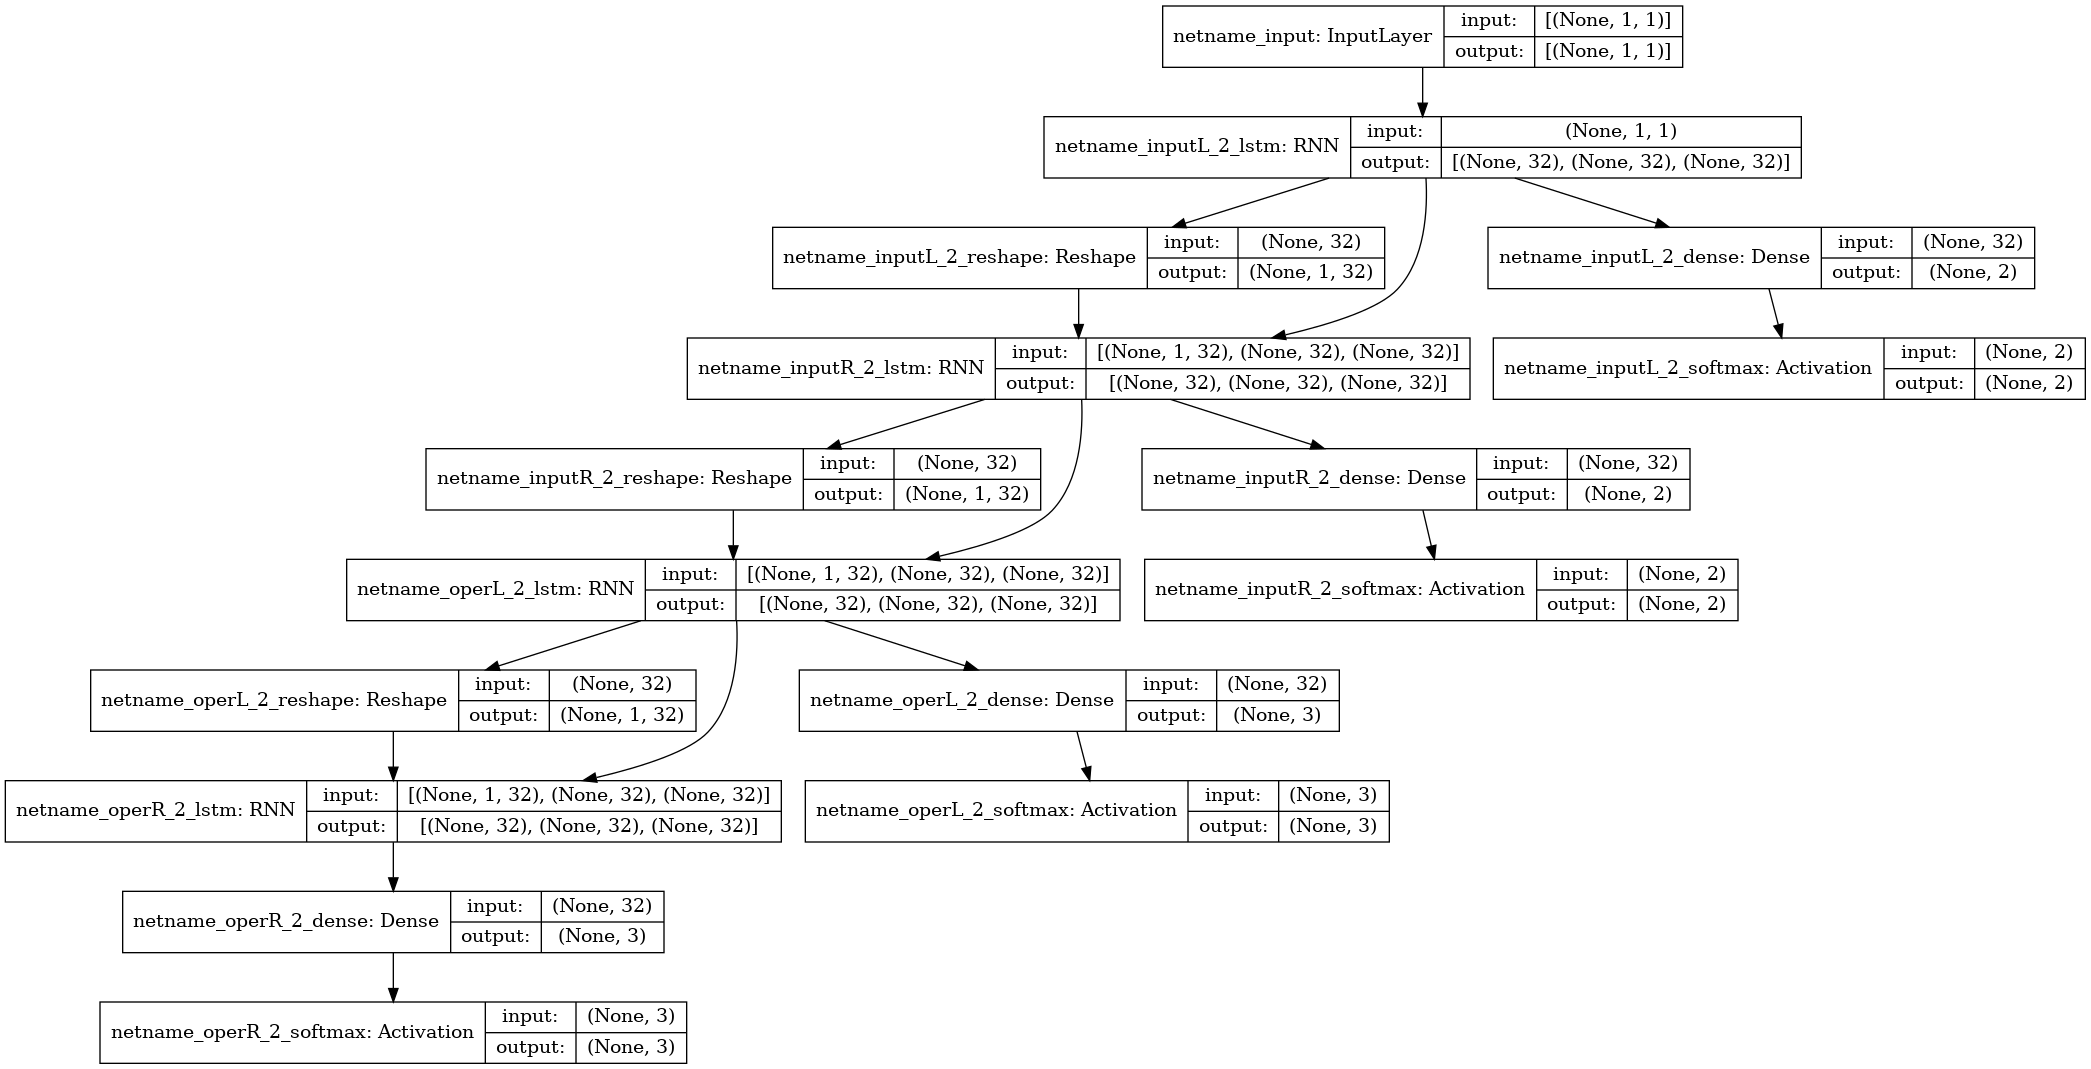

In [10]:
from tensorflow.keras.utils import plot_model

#contr.controller_rnn.summary()
plot_model(contr.controller_rnn, expand_nested=True, show_shapes=True)

# Test LSTM

In [3]:
import tensorflow as tf

import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)

whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)

print(whole_seq_output.shape, final_memory_state.shape, final_carry_state.shape)

(32, 10, 4) (32, 4) (32, 4)
